# Linear & non-linear limit of diffusion under OU policy
## TOC:
* [Comparison of analytical results and numerics of OU process in linear limit](#first-bullet)
* [Computing diffusion of the agent in the non-linear limit](#second-bullet)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
import copy

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node

import time
import random as rm
import pandas as pd

In [2]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

## Only OU process validation
Dynamics of an agent whose orientation is described by the Ornstein-Uhlenbeck process is given by

$
\dot{\theta}(t) = - \alpha \theta(t) + \sqrt{2D} \eta(t)
$

$
\langle \eta(t) \eta(t') \rangle = \delta(t-t')
$

In [5]:
# Parameters in the model
class ouParams():
    def __init__(self) -> None:
        super().__init__()
        # Simulation parameters
        self.nSteps = 20000
        self.nEpchs = 1000
        # Dynamics parameters
        self.dt = 25e-5
        self.alpha = 3
        self.diff = 0.125
        # Initial condition
        self.thInit = 2.*np.ones((self.nEpchs))

In [6]:
# Single step dynamics of the agent
class ouProcess():
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.thet = p.thInit
    
    def stepFwd(self, ptr):
        p = copy.deepcopy(ptr)
        self.thet = self.thet*(1-p.alpha*p.dt) + np.sqrt(2*p.diff*p.dt)*np.random.normal(0., 1., p.nEpchs)

In [7]:
# Single epoch of OU dynamics for p.nSteps
p = ouParams()
ag = ouProcess(p)
start_time = time.time()
thetFull = np.array(p.thInit)

dfthet = pd.DataFrame()

for i in range(p.nSteps):
    ag.stepFwd(p)
    thetFull = np.vstack((thetFull, np.array(ag.thet)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 552.4232940673828 seconds ---


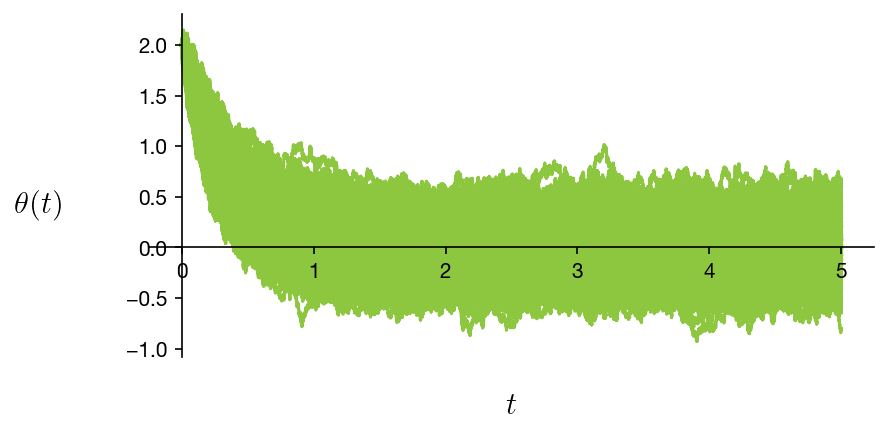

In [8]:
dfthet = pd.DataFrame(thetFull)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(6, 3), dpi=150)
nRow = 1
nCol = 1
ax = plt.subplot(nRow, nCol, 1)
t = np.arange(0,p.nSteps+1)*p.dt
ax.plot(t, thetFull, color=color, zorder=-1)
ax.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax.set_ylabel(r'$\theta (t)$',usetex=True,rotation=0, fontsize=label_size)

ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.15,0.4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))

plt.tight_layout()
plt.show()

### Analytical forumula for variance

$\zeta(t) = \dfrac{D}{\alpha}[1-\exp(-2\alpha t)]$

In [42]:
# Variance analytical expression for OU process
def varAlt(t, ptr):
    p = copy.deepcopy(ptr)
    return p.diff*(1-np.exp(-2*p.alpha*t))/p.alpha
    

/Users/kalyani/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/kalyani/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


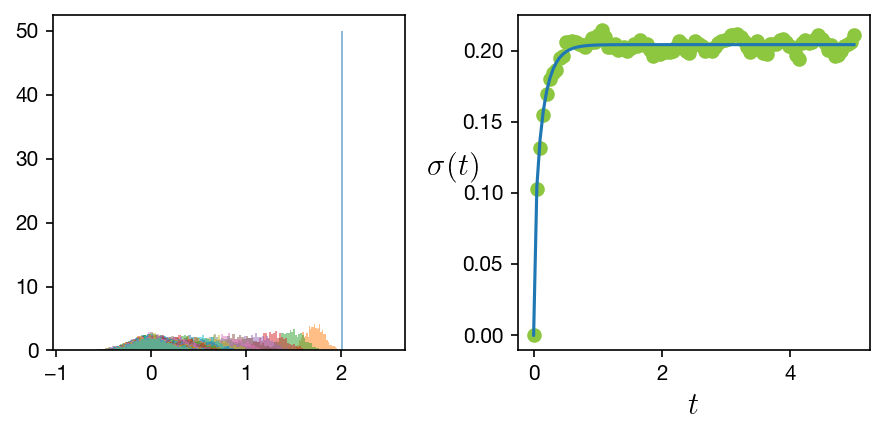

In [56]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(6, 3), dpi=150)
nRow = 1
nCol = 2
ax1 = plt.subplot(nRow, nCol, 1)
ax2 = plt.subplot(nRow, nCol, 2)
for tTest in np.linspace(0,5,100):
    ind = int(tTest/p.dt)
    _, bins, _ = ax1.hist(thetFull[ind,:], 50, density=1, alpha=0.5)
    mu, sigma = scipy.stats.norm.fit(thetFull[ind,:])
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    ax2.scatter(tTest, sigma, color = color)
tFull = np.linspace(0,5,100)
ax2.plot(tFull, varAlt(tFull, p)**0.5)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\sigma(t)$',usetex=True,rotation=0, fontsize=label_size)
plt.tight_layout()
plt.show()

### Validation of variance with OU-process + position movement

In [80]:
# Parameters in the model
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nSteps = 800
        self.nEpchs = 500
        
        self.dt = 1e-2
        self.l = 5e-3
        self.vo = self.l/self.dt
        self.alpha = 2
        self.diff = 30/jnp.pi
        
        self.rInit = jnp.array([0.0, 0.0])
        self.thInit = 0.

In [81]:
# Single step dynamics of the agent
class agent():
    def __init__(self, r, thet, rng):
        super().__init__()
        self.r = r
        self.thet = thet
        self.rng = rng
    
    @jit
    def stepFwd(self, dt, l, diff, alpha):
        drng = random.split(self.rng)[0]
        # self.r += l*jnp.array([jnp.cos(self.thet), jnp.sin(self.thet)])
        self.r += l*jnp.array([1., self.thet])
        self.thet = self.thet*(1-alpha*dt) + jnp.sqrt(2*diff*dt)*random.normal(drng)
        return agent(self.r, self.thet, drng)
    
register_pytree_node(agent,
                     lambda x: ((x.r[0], x.r[1], x.thet, x.rng), None),
                     lambda _, tup: agent(jnp.array([tup[0], tup[1]]), tup[2], tup[3]))

 ## <a class="anchor" id="first-bullet">Single epoch of agent dynamics</a>

--- 1.3682401180267334 seconds ---


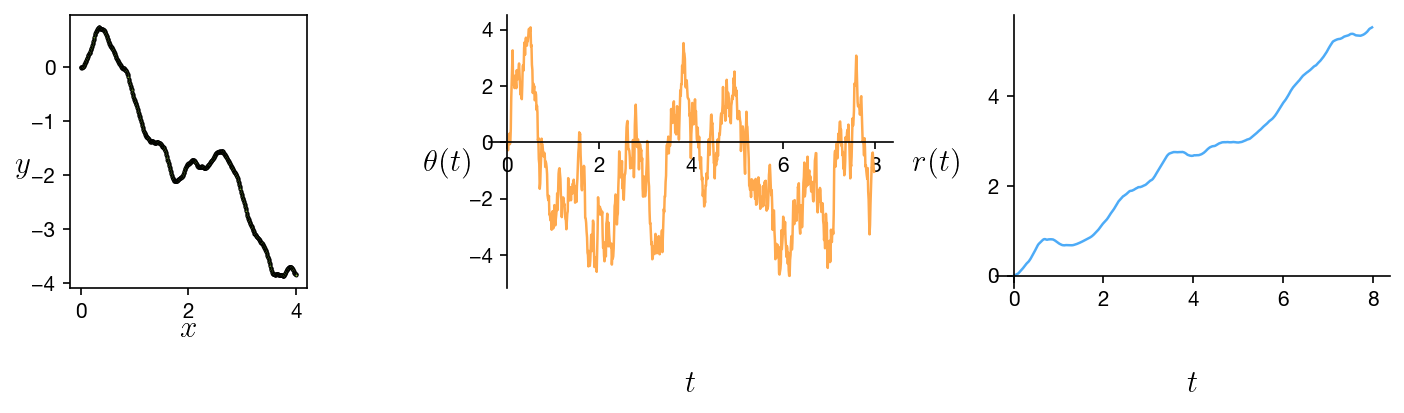

In [82]:
# Single epoch of agent dynamics for p.nSteps
rng = random.PRNGKey(rm.randint(0,10000))
p = params()
ag = agent(p.rInit, p.thInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
thetFull = np.array(p.thInit)

dfx = pd.DataFrame()
dfy = pd.DataFrame()

for i in range(p.nSteps):
    ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    thetFull = np.vstack((thetFull, np.array(ag.thet)))
    # dfx[i] = rxFull.tolist()
    # dfy[i] = ryFull.tolist()
print("--- %s seconds ---" % (time.time() - start_time))

dfx = pd.DataFrame(rxFull)
dfy = pd.DataFrame(ryFull)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

nRow = 1
nCol = 3
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)
ax1.scatter(rxFull, ryFull,
            s=2,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            zorder=-1)
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.1)
ax1.yaxis.set_label_coords(-0.2,0.4)


ax2 = plt.subplot(nRow, nCol, 2)
t = jnp.arange(p.nSteps)*p.dt
# ax2.plot(t, np.mod(thetFull[:-1],2*np.pi),
ax2.plot(t, thetFull[:-1],
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax2.set_ylim([0.,2*np.pi])

ax2.xaxis.set_label_coords(0.5,-0.3)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))

ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
        color=colors['blue'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax3.set_ylim([0.,2*np.pi])

ax3.xaxis.set_label_coords(0.5,-0.3)
ax3.yaxis.set_label_coords(-0.15,0.4)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_position(("data", 0))
ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

 ## <a class="anchor" id="second-bullet">Several epochs of dynamics</a>

/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_33226/1586216806.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfx[ind] = rxFull.flatten().tolist()
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_33226/1586216806.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfy[ind] = ryFull.flatten().tolist()
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_33226/1586216806.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

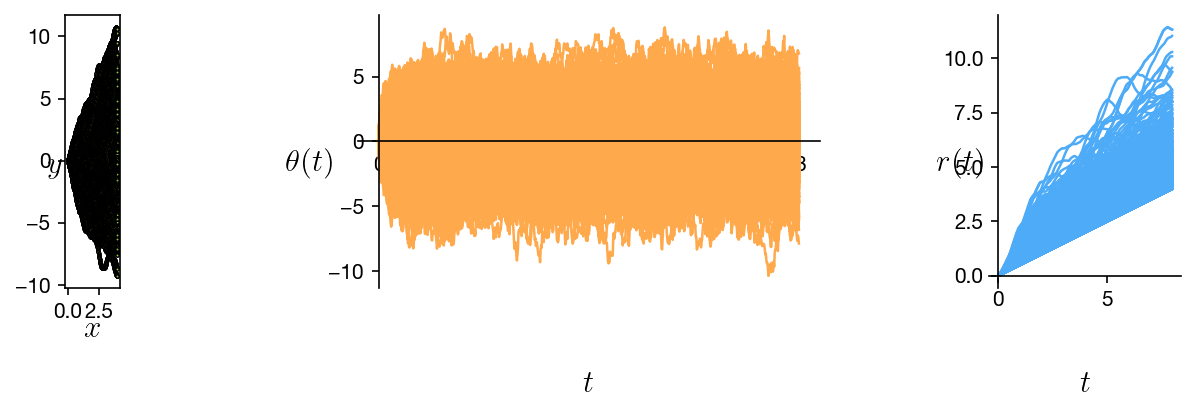

In [83]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

p = params()
dfx = pd.DataFrame()
dfy = pd.DataFrame()
# for ind in np.arange(p.nEpchs):
for ind in np.arange(1000):
    rng = random.PRNGKey(rm.randint(0,10000))
    ag = agent(p.rInit, p.thInit, rng)
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    thetFull = np.array(p.thInit)
    for i in range(p.nSteps):
        ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
        rxFull = np.vstack((rxFull, ag.r[0]))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        thetFull = np.vstack((thetFull, np.array(ag.thet)))
    dfx[ind] = rxFull.flatten().tolist()
    dfy[ind] = ryFull.flatten().tolist()
    nRow = 1
    nCol = 3
    ax1 = plt.subplot(nRow, nCol, 1, aspect=1)

    ax1.scatter(rxFull, ryFull,
                s=2,
                color=color,
                edgecolors='k',
                linewidth=0.5,
                zorder=-1)
    ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
    ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

    ax1.xaxis.set_label_coords(0.5,-0.1)
    ax1.yaxis.set_label_coords(-0.2,0.4)


    ax2 = plt.subplot(nRow, nCol, 2)
    t = jnp.arange(p.nSteps)*p.dt
    ax2.plot(t, thetFull[:-1],
            color=colors['orange'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)

    ax2.xaxis.set_label_coords(0.5,-0.3)
    ax2.yaxis.set_label_coords(-0.1,0.4)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_position(("data", 0))
    ax2.spines["bottom"].set_position(("data", 0))

    ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
    ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
            color=colors['blue'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
    ax3.xaxis.set_label_coords(0.5,-0.3)
    ax3.yaxis.set_label_coords(-0.15,0.4)

    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_position(("data", 0))
    ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

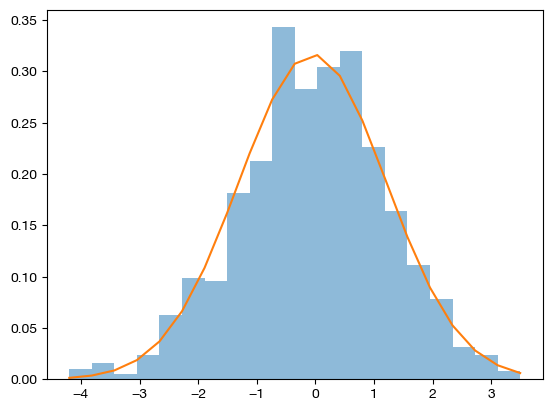

In [84]:
ind = 200
_, bins, _ = plt.hist(dfy.iloc[ind,:], 20, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(dfy.iloc[ind,:])
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.show()

In [85]:
# Variance analytical expression for OU process
def varAgent(t, ptr):
    p = copy.deepcopy(ptr)
    return p.diff*(2*p.alpha*t - np.exp(-2*p.alpha*t) + 4*np.exp(-p.alpha*t) - 3)*p.vo**2/p.alpha**3
    

/Users/kalyani/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/kalyani/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


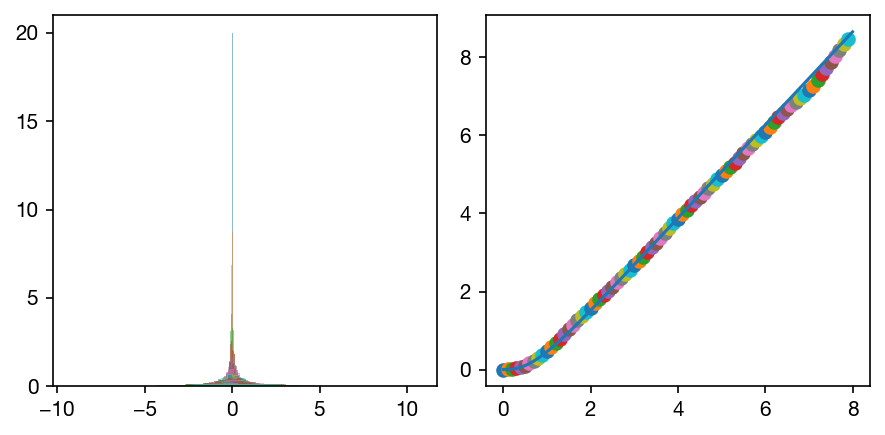

In [86]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(6, 3), dpi=150)
nRow = 1
nCol = 2
ax1 = plt.subplot(nRow, nCol, 1)
ax2 = plt.subplot(nRow, nCol, 2)

for ind in np.arange(0,800,10):
    _, bins, _ = ax1.hist(dfy.iloc[ind,:], 20, density=1, alpha=0.5)
    mu, sigma = scipy.stats.norm.fit(dfy.iloc[ind,:])
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    ax2.plot(ind*p.dt, sigma**2,'o')
tFull = np.linspace(0,8,100)
ax2.plot(tFull, varAgent(tFull, p))
plt.tight_layout()
plt.show()